In [1]:
import os
import functools
from itertools import groupby
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

from codon_hamiltonian import *

---
# Amino_acid_to Codon

Input: Amino acid sequence

In [100]:
"""
def fragmenting_amino_acid_seq(Amino_acid_seq, length_frag, ith):
    return Amino_acid_seq[length_frag * (ith-1):length_frag * (ith)]
"""

'\ndef fragmenting_amino_acid_seq(Amino_acid_seq, length_frag, ith):\n    return Amino_acid_seq[length_frag * (ith-1):length_frag * (ith)]\n'

In [101]:
#spike_sars2_seq = 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT'
A0A2U1LIM9 = 'MQSTTSVKLSPFDLMTALLNGKVSFDTSNTSDTNIPLAVFMENRELLMILTTSVAVLIGCVVVLVWRRSSSAAKKAAESPVIVVPKKVTEDEVDDGRKKVTVFFGTQTGTAEGFAKALVEEAKARYEKAVFKVIDLDDYAAEDDEYEEKLKKESLAFFFLATYGDGEPTDNAARFYKWFTEGEEKGEWLEKLQYAVFGLGNRQYEHFNKIAKVVDEKLVEQGAKRLVPVGMGDDDQCIEDDFTAWKELVWPELDQLLRDEDDTSVATPYTAAVAEYRVVFHDKPETYDQDQLTNGHAVHDAQHPCRSNVAVKKELHSPLSDRSCTHLEFDISNTGLSYETGDHVGVYVENLSEVVDEAEKLIGLPPHTYFSVHTDNEDGTPLGGASLPPPFPPCTLRKALASYADVLSSPKKSALLALAAHATDSTEADRLKFLASPAGKDEYAQWIVASHRSLLEVMEAFPSAKPPLGVFFASVAPRLQPRYYSISSSPKFAPNRIHVTCALVYEQTPSGRVHKGVCSTWMKNAVPMTESQDCSWAPIYVRTSNFRLPSDPKVPVIMIGPGTGLAPFRGFLQERLAQKEAGTELGTAILFFGCRNRKVDFIYEDELNNFVETGALSELVTAFSREGATKEYVQHKMTQKASDIWNLLSEGAYLYVCGDAKGMAKDVHRTLHTIVQEQGSLDSSKAELYVKNLQMAGRYLRDVW'

test_amino_seq = fragmenting_amino_acid_seq(A0A2U1LIM9, 3, 1)
test_amino_seq

'TTS'

Enumerating all poissible codons of an input

In [102]:
codon_seq = Amino_acid_to_Codon(test_amino_seq)
codon_seq()

[['ACA', 'ACC', 'ACG', 'ACU'],
 ['ACA', 'ACC', 'ACG', 'ACU'],
 ['AGC', 'AGU', 'UCA', 'UCC', 'UCG', 'UCU']]

Codon Seq. from RNA basis to DNA basis

In [103]:
codon_seq_in_dna_base = codon_seq.in_dna_base()
print(codon_seq())
print(codon_seq_in_dna_base)

[['ACA', 'ACC', 'ACG', 'ACU'], ['ACA', 'ACC', 'ACG', 'ACU'], ['AGC', 'AGU', 'UCA', 'UCC', 'UCG', 'UCU']]
[['ACA', 'ACC', 'ACG', 'ACT'], ['ACA', 'ACC', 'ACG', 'ACT'], ['AGC', 'AGT', 'TCA', 'TCC', 'TCG', 'TCT']]


---
# Codon_Hamiltonian

parameters

In [104]:
weight_params = {'c_f': 0.1, 'c_GC': 1, 'c_R': 0.1, 'c_L': 1, 'epsilon_f': 0.001, 'rho_T': 0.5, 'epsilon': 1, 'infty': 10}
H_codon = Codon_Hamiltonian(test_amino_seq, weight_params)

## 1. Incorporating codon usage bias

$$
\mathcal{H}_f = c_f\sum^N_i\log\left[C_i + \varepsilon_f\right]q_i
$$

codon frequency table

In [6]:
import python_codon_tables as pct
# PRINT THE LIST OF NAMES OF ALL AVAILABLE TABLES
print ('Available tables:', pct.available_codon_tables_names)
table = pct.get_codons_table('e_coli_316407')
table['A']

#Table
col1 = test_amino_seq
col2 = [table[x] for x in test_amino_seq]
two_dim_list = [[col1[x], col2[x]] for x in range(len(test_amino_seq))]


my_data = pd.DataFrame(two_dim_list, columns = ['Amino acid sequence', 'Frequences of all possible codons'])
print(my_data)

Available tables: ['b_subtilis_1423', 'd_melanogaster_7227', 'm_musculus_domesticus_10092', 'm_musculus_10090', 'e_coli_316407', 'g_gallus_9031', 'c_elegans_6239', 's_cerevisiae_4932', 'h_sapiens_9606']
  Amino acid sequence                  Frequences of all possible codons
0                   M                                       {'ATG': 1.0}
1                   Q                         {'CAA': 0.35, 'CAG': 0.65}
2                   S  {'AGC': 0.28, 'AGT': 0.15, 'TCA': 0.12, 'TCC':...


$\vec{\zeta}$, where $\zeta_i = \log(C_i+\varepsilon_f)$

In [8]:
H_codon.vec_zeta(epsilon_f=0)

array([ 0.        , -1.04982212, -0.43078292, -1.27296568, -1.89711998,
       -2.12026354, -1.89711998, -1.89711998, -1.89711998])

$\mathcal{H}_f$

In [9]:
H_codon.H_f

array([-9.99500333e-05,  1.04696906e-01,  4.29245637e-02,  1.26940061e-01,
        1.89047544e-01,  2.11196473e-01,  1.89047544e-01,  1.89047544e-01,
        1.89047544e-01])

## 2. Optimize target GC concentration

$$
\rho_{GC} = \frac{1}{L}\sum^N_{i} s_i q_i,
$$
where $s_i$: the number of G's and C's in the $i$ th codon and $L$ : the length of the codon sequence.

$\vec{s}$

In [ ]:
H_codon.vec_s()

$\vec{s}\otimes\vec{s}$

In [106]:
upper_trianglular_part, diagonal_part = H_codon.matrix_ss()

$$
\mathcal{H}_{GC} = \frac{2c_{GC}}{L^2}\sum^N_i\sum^N_{j<i} s_is_jq_iq_j + \sum^N_i \left(\frac{c_{GC}}{L^2}s^2_i - \frac{2\rho_Tc_{GC}}{L}s_i\right)q_i + c_{GC}\rho^2_T
$$

In [12]:
quadratic_coeff, linear_coeff, const = H_codon.H_GC

In [13]:
np.max(quadratic_coeff)

-0.09876543209876543

## 3. Minimize sequentially repeated nuceotides

$$
\mathcal{H}_R = c_R\sum^N_i\sum^{N}_{j<i} R_{ij}q_iq_j,
$$
$$
R_{ij} = r(C_i, C_J) \kappa_{i,j}
$$

$r(C_i, C_j)$

In [14]:
# r(C_i, C_j)
def repeated_sequential_nucleotides(Ci, Cj):
    input = Ci + Cj
    groups = groupby(input)
    result = [(label, len(list(group))) for label, group in groups]
    list_counts = np.array(result)[:,1]
    outcome = np.max(list_counts.astype('int'))
    return outcome ** 2 - 1

In [15]:
H_codon._repeated_sequential_nucleotides('AUG', 'CAA')

3

$R_{ij}$

In [16]:
H_codon.matrix_R()

array([[0., 3., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 8., 8., 3., 3., 3., 3.],
       [0., 0., 0., 0., 0., 0., 3., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [17]:
np.max(H_codon.matrix_R())

8.0

## 4. Additional constraints

$$
\mathcal{H}_p = -\sum^N_i \epsilon q_i + \sum^N_i\sum^N_{j<i} \tau_{ij}q_iq_j
$$

In [18]:
H_codon.matrix_tau()

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., 50.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 50., 50., 50., 50., 50.],
       [ 0.,  0.,  0.,  0.,  0., 50., 50., 50., 50.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 50., 50., 50.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 50., 50.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 50.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

## 5. Conservation of the length of polypeptide

$$
\mathcal{H}_L = c_L\left(1-\frac{1}{l}\sum^N_{i=1}q_i\right)^2
= c_L\left[1 + \left(\frac{1}{l^2}-\frac{2}{l}\right)\sum^N_{i=1} q_i + \frac{2}{l^2}\sum^N_{i=1}\sum^{N}_{i<j}q_iq_j \right]
$$

$$
L_{ii} = \left(\frac{1}{l^2}-\frac{2}{l}\right)I \\ 
L_{ij} = \frac{2}{l^2} \text{ for } i<j
$$

In [19]:
H_codon.matrix_L()

[array([-0.55555556, -0.55555556, -0.55555556, -0.55555556, -0.55555556,
        -0.55555556, -0.55555556, -0.55555556, -0.55555556]),
 array([[0.        , 0.22222222, 0.22222222, 0.22222222, 0.22222222,
         0.22222222, 0.22222222, 0.22222222, 0.22222222],
        [0.        , 0.        , 0.22222222, 0.22222222, 0.22222222,
         0.22222222, 0.22222222, 0.22222222, 0.22222222],
        [0.        , 0.        , 0.        , 0.22222222, 0.22222222,
         0.22222222, 0.22222222, 0.22222222, 0.22222222],
        [0.        , 0.        , 0.        , 0.        , 0.22222222,
         0.22222222, 0.22222222, 0.22222222, 0.22222222],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.22222222, 0.22222222, 0.22222222, 0.22222222],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.22222222, 0.22222222, 0.22222222],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0

## 6. Codon Hamiltonian

$$
\mathcal{H} = \sum^N_i Q_{ii} q_i + \sum^N_i\sum^N_{j<i}Q_{ij}q_iq_j + c_{GC}\rho^2_T.
$$

$$
Q_{ii} = c_f\zeta_i - \frac{2\rho_Tc_{GC}}{N}s_i + \frac{c_{GC}}{N^2}s^2_i - \varepsilon + c_LL_{i}
$$
$$
Q_{ij} = \frac{2c_{GC}}{N^2}\sigma_{ij} + c_R R_{ij} + \tau_{ij} + c_L L_{ij}
$$

In [29]:
np.max(H_codon.Q_ii), np.min(H_codon.Q_ii)

(-1.4431245143157814, -1.6854704980510382)

In [30]:
np.max(H_codon.Q_ij), np.min(H_codon.Q_ij)

(10.320987654320987, 0.0)

---
# Simulating a Toy Model 

test input

In [48]:
#spike_sars2_seq = 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT'
A0A2U1LIM9 = 'MQSTTSVKLSPFDLMTALLNGKVSFDTSNTSDTNIPLAVFMENRELLMILTTSVAVLIGCVVVLVWRRSSSAAKKAAESPVIVVPKKVTEDEVDDGRKKVTVFFGTQTGTAEGFAKALVEEAKARYEKAVFKVIDLDDYAAEDDEYEEKLKKESLAFFFLATYGDGEPTDNAARFYKWFTEGEEKGEWLEKLQYAVFGLGNRQYEHFNKIAKVVDEKLVEQGAKRLVPVGMGDDDQCIEDDFTAWKELVWPELDQLLRDEDDTSVATPYTAAVAEYRVVFHDKPETYDQDQLTNGHAVHDAQHPCRSNVAVKKELHSPLSDRSCTHLEFDISNTGLSYETGDHVGVYVENLSEVVDEAEKLIGLPPHTYFSVHTDNEDGTPLGGASLPPPFPPCTLRKALASYADVLSSPKKSALLALAAHATDSTEADRLKFLASPAGKDEYAQWIVASHRSLLEVMEAFPSAKPPLGVFFASVAPRLQPRYYSISSSPKFAPNRIHVTCALVYEQTPSGRVHKGVCSTWMKNAVPMTESQDCSWAPIYVRTSNFRLPSDPKVPVIMIGPGTGLAPFRGFLQERLAQKEAGTELGTAILFFGCRNRKVDFIYEDELNNFVETGALSELVTAFSREGATKEYVQHKMTQKASDIWNLLSEGAYLYVCGDAKGMAKDVHRTLHTIVQEQGSLDSSKAELYVKNLQMAGRYLRDVW'
HPDF_amino = 'EGPALRRSYWRHLRRLVLGPPEPPFSHVCQVGDPVLRGVAAPVERAQLGGPELQRLTQRLVQVMRRRRCVGLSAPQLGVPRQVLALELPEALCRECPPRQRALRQMEPFPLRVFVNPSLRVLDSRLVTFPEGCESVAGFLACVPRFQAVQISGLDPNGEQVVWQASGWAARIIQHEMDHLQGCLFIDKMDSRTFTNVYWMKVND'

In [50]:
amino_seq = fragmenting_amino_acid_seq(HPDF_amino, 5, 0)
codon_seq = Amino_acid_to_Codon(amino_seq)
print('Amino acid seq:', amino_seq)
print('All possible codons:', codon_seq())

Amino acid seq: EGPAL
All possible codons: [['GAA', 'GAG'], ['GGA', 'GGC', 'GGG', 'GGU'], ['CCA', 'CCC', 'CCG', 'CCU'], ['GCA', 'GCC', 'GCG', 'GCU'], ['CUA', 'CUC', 'CUG', 'CUU', 'UUA', 'UUG']]


Preparing H_codon

In [52]:
#weight_params = {'c_f': -0.1, 'c_GC': 1, 'c_R': 0.1, 'c_L': 1, 'epsilon_f': 0.001, 'rho_T': 0.5, 'epsilon': 1, 'infty': 10}
#weight_params = {'c_f': 0, 'c_GC': 1, 'c_R': 0, 'c_L': 0, 'epsilon_f': 0.00, 'rho_T': 0.5, 'epsilon': 0, 'infty': 0}
weight_params = {'c_f': 0, 'c_GC': 1, 'c_R': 0, 'c_L': 0, 'epsilon_f': 0.000, 'rho_T': 0.5, 'epsilon': 2, 'infty': 4}
H_codon = Codon_Hamiltonian(amino_seq, weight_params)

## 1. D-wave

Constructing Q_{ij} as dict type

In [53]:
Q = H_codon.get_Q_dict()

### Simulation

In [54]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

#import matplotlib
#matplotlib.use("agg")
#from matplotlib import pyplot as plt

In [55]:
# ------- Run our QUBO on the QPU -------
# Set up QPU parameters
#이건 우리가 최적화 해야할듯?
chainstrength = 15 #min: 12
numruns = 10000

In [56]:
# Run the QUBO on the solver from your config file
sampler = EmbeddingComposite(DWaveSampler())
response = sampler.sample_qubo(Q,
                               #chain_strength=chainstrength,
                               num_reads=numruns,
                               #num_spin_reversal_tramsforms=50,
                               label='Codon_sequence')

In [57]:
def get_min_res(response):
    min_E = min(response.data(fields=['energy']))[0]
    
    min_indices = []
    for i, x in enumerate(response.data(fields=['energy'])):
        if x == min_E:
            min_indices.append(i) 
        else: 
            break

    sample_list = np.array(list(response.data(fields=['sample'])))[:,0]
    min_sample_list = sample_list[min_indices]

    min_samples = []
    for x in min_indices:
        a_min_sample = [k for k,v in min_sample_list[x].items() if v == 1]
        if a_min_sample not in min_samples: #remove duplicates of min_sample
            min_samples.append(a_min_sample) 
    
    return min_samples, min_E

In [97]:
#get_min_res(response)

In [59]:
def get_min_res1(response): #more effective for memory usage
    min_E = min(response.data(fields=['energy']))[0]

    min_indices = []
    for i, x in enumerate(response.data(fields=['energy'])):
        if x == min_E:
            min_indices.append(i) 
        else: 
            break

    min_samples = []
    i_min = 0
    for x in response.data(fields=['sample']):
        a_min_sample = [k for k,v in x[0].items() if v == 1]
        if a_min_sample not in min_samples: #remove duplicates of min_sample
            min_samples.append(a_min_sample) 
            
        if i_min == min_indices[-1]:
            break
        else:
            i_min += 1

    return min_samples, min_E

In [98]:
#get_min_res1(response)[0]

In [67]:
print('-' * 60)
print('{:>15s}{:>15s}{:^15s}{:^15s}'.format('Set 0','Set 1','Energy','Cut Size'))
print('-' * 60)
for sample, E in response.data(fields=['sample','energy']):
    S0 = [k for k,v in sample.items() if v == 0]
    S1 = [k for k,v in sample.items() if v == 1]
    print('{:>15s}{:^15s}{:^15s}'.format(str(S1),str(E),str(int(-1*E))))

------------------------------------------------------------
          Set 0          Set 1    Energy        Cut Size    
------------------------------------------------------------
[0, 3, 6, 10, 15]-10.250000000000004      10       
[0, 4, 9, 10, 16]-10.250000000000004      10       
[1, 5, 6, 13, 16]-10.250000000000004      10       
[0, 4, 6, 13, 16]-10.250000000000004      10       
[1, 2, 6, 13, 15]-10.250000000000004      10       
[1, 2, 9, 13, 15]-10.250000000000004      10       
[1, 5, 6, 10, 15]-10.250000000000004      10       
[0, 4, 6, 10, 15]-10.250000000000004      10       
[0, 3, 6, 10, 15]-10.250000000000004      10       
[0, 3, 6, 13, 16]-10.250000000000004      10       
[1, 2, 6, 10, 15]-10.250000000000004      10       
[0, 4, 6, 10, 15]-10.250000000000004      10       
[1, 2, 9, 10, 15]-10.250000000000004      10       
[1, 2, 6, 10, 15]-10.250000000000004      10       
[0, 3, 6, 13, 15]-10.250000000000004      10       
[0, 4, 9, 13, 15]-10.250000000000004 

new $\mathcal{H}_L$

[0, 2, 3, 11, 16, 17, 25]-7.537854785825701 <br>
[0, 2, 4, 11, 15, 17, 25]-7.527818748163343  <br>

[0, 2, 8, 12, 15, 17, 25, 28]-8.02910625876468

[0, 2, 3, 11, 15, 17, 25]-6.592669715640199        <br>

[0, 2, 3, 11, 15, 17, 25, 28]-7.150419551458638  <br>
[0, 2, 3, 11, 15, 17, 24, 28]-7.0986156153496704       <br>
[0, 2, 4, 11, 15, 17, 25, 28]-7.085933946922571  <br>
[0, 2, 4, 11, 15, 17, 24, 28]-7.034130010813604 

In [11]:
H_codon.list_all_possible_codons

[['AUG'],
 ['CAA', 'CAG'],
 ['AGC', 'AGU', 'UCA', 'UCC', 'UCG', 'UCU'],
 ['ACA', 'ACC', 'ACG', 'ACU']]

In [12]:
H_codon.run_Dwave()

([0, 2, 3, 11], -4.948192389640039)

In [14]:
H_codon.opt_codon_seq(base='DNA')

['ATG', 'CAG', 'AGC', 'ACG']

## 2. Exact Diagonalization

Constructing Ising model from QUBO & Running 

In [32]:
J, h, const = H_codon.Q_to_Jh()

In [33]:
tests = Quantum_Ising(J=J, h=h, shift=const)
tests.hamiltonian

array([[-25.59094802,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        , -27.41729893,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        , -26.22394128, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,  61.22394128,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
         62.41729893,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,  90.59094802]])

In [34]:
GS = tests.ExactDiag()
vec_to_braket(GS)

{'|0110000100>': 1.0}

In [35]:
tests.GE

-5.4781521778580995

---
# Run Simulator

In [2]:
HPDF_amino = 'EGPALRRSYWRHLRRLVLGPPEPPFSHVCQVGDPVLRGVAAPVERAQLGGPELQRLTQRLVQVMRRRRCVGLSAPQLGVPRQVLALELPEALCRECPPRQRALRQMEPFPLRVFVNPSLRVLDSRLVTFPEGCESVAGFLACVPRFQAVQISGLDPNGEQVVWQASGWAARIIQHEMDHLQGCLFIDKMDSRTFTNVYWMKVND'
print('Length of full seq:', len(HPDF_amino))

Length of full seq: 204


## ED

### 1. Run all

In [3]:
weight_params = {'c_f': 1, 'c_GC': 0, 'c_R': 0, 'c_L': 0, 'epsilon_f': 0.001, 'rho_T': 0.5, 'epsilon': 2, 'infty': 4}

In [7]:
select_q1

[[0, 3]]

In [ ]:
block_size = 2
verbose = 0

aminoacid_block = []
ED_codons = []
min_E_list = []

print("* Running", end=' ') if verbose == 0 else None
for ith in range(len(HPDF_amino) // block_size + 1):
    amino_fragment = fragmenting_amino_acid_seq(HPDF_amino, block_size, ith)
    codon_fragment = Amino_acid_to_Codon(amino_fragment)
        
    if verbose >= 1:
        print('In amino acide seq, Run Block:',str(ith))
        print('=> Amino acids:', amino_fragment)
    if verbose >= 2:
        print('=> All possible codons:', codon_fragment())
    #====================
    
    #construct H_codon
    H_codon = Codon_Hamiltonian(amino_fragment, weight_params)
    J, h, const = H_codon.Q_to_Jh()
    #run Exact Diagonalization
    H_codon = Quantum_Ising(J=J, h=h, shift=const)
    H_codon.run_ExactDiag()
    select_q1 = H_codon.get_outcome(types='list')
    opt_codon_frag = codon_fragment(select_q1[0])
    
    #====================
    if verbose ==0:
        print(".", end=' ')
    elif verbose >= 2:
        print('=> Ground states:', min_sample)
    elif verbose >= 1:
        print('=> Optimal codons:', opt_codon_frag)


    aminoacid_block.append(amino_fragment)
    ED_codons.append(opt_codon_frag)
    min_E_list.append(H_codon.ground_energy)


In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

opt_codon_list = ["".join(ED_codons[x]) for x in range(len(ED_codons))]
rslt_df = pd.DataFrame(list(zip(aminoacid_block, opt_codon_list, min_E_list)),
                        columns=['amino acid', 'codon', "Energy"])
rslt_df

,amino acid,codon,Energy


### 2. Run_ED for just one frag

#### TEST1:  Codon Usage Frequency

$c_f = 1$ is fixed. <br>
$\infty = 2 * \epsilon$ <br>
block size = $\epsilon$


In [13]:
weight_params = {'c_f': 1, 'c_GC': 0, 'c_R': 0, 'c_L': 0, 'epsilon_f': 0.000, 'rho_T': 0.5, 'epsilon': 2, 'infty': 4}
# epsilon

In [14]:
block_size = 2
block_position = 1

amino_fragment = fragmenting_amino_acid_seq(HPDF_amino, block_size, block_position)
print('=> Amino acids:', amino_fragment)
codon_fragment = Amino_acid_to_Codon(amino_fragment)
print('=> All possible codons:', codon_fragment())


H_codon = Codon_Hamiltonian(amino_fragment, weight_params)
J, h, const = H_codon.Q_to_Jh()
H_codon_matrix = Quantum_Ising(J=J, h=h, shift=0) #shift=const
H_codon_matrix.run_ExactDiag()

# Pick sites where qubit=1
select_q1 = H_codon_matrix.get_outcome(types='list')

# outcome All optimal codon seqs
print('=> All optimal codons:')
for x in select_q1:
    print(codon_fragment(x))

print(H_codon_matrix.ground_energy)

=> Amino acids: PA
=> All possible codons: [['CCA', 'CCC', 'CCG', 'CCU'], ['GCA', 'GCC', 'GCG', 'GCU']]
=> All optimal codons:
['CCG', 'GCG']
-12.329804609399421


#### TEST2: GC Contents

In [144]:
weight_params = {'c_f': 0, 'c_GC': 10, 'c_R': 0, 'c_L': 0, 'epsilon_f': 0.000, 'rho_T': 0.5, 'epsilon': 2, 'infty': 4}

In [145]:
block_size = 2
block_position = 1

amino_fragment = fragmenting_amino_acid_seq(HPDF_amino, block_size, block_position)
print('=> Amino acids:', amino_fragment)
codon_fragment = Amino_acid_to_Codon(amino_fragment)
print('=> All possible codons:', codon_fragment())


H_codon = Codon_Hamiltonian(amino_fragment, weight_params)
J, h, const = H_codon.Q_to_Jh()
H_codon_matrix = Quantum_Ising(J=J, h=h, shift=0) #shift=const
H_codon_matrix.run_ExactDiag()

# Pick sites where qubit=1
select_q1 = H_codon_matrix.get_outcome(types='list')

# outcome All optimal codon seqs
print('=> All optimal codons:')
for x in select_q1:
    print(codon_fragment(x))

print(H_codon_matrix.ground_energy)

=> Amino acids: PA
=> All possible codons: [['CCA', 'CCC', 'CCG', 'CCU'], ['GCA', 'GCC', 'GCG', 'GCU']]
=> All optimal codons:
['CCU', 'GCU']
['CCU', 'GCA']
['CCA', 'GCU']
['CCA', 'GCA']
-15.65625


#### TEST3: Codon Usage Frequency + GC Contents

In [142]:
weight_params = {'c_f': 0.1, 'c_GC': 10, 'c_R': 0, 'c_L': 0, 'epsilon_f': 0.000, 'rho_T': 0.5, 'epsilon': 2, 'infty': 4}

In [143]:
block_size = 2
block_position = 1

amino_fragment = fragmenting_amino_acid_seq(HPDF_amino, block_size, block_position)
print('=> Amino acids:', amino_fragment)
codon_fragment = Amino_acid_to_Codon(amino_fragment)
print('=> All possible codons:', codon_fragment())


H_codon = Codon_Hamiltonian(amino_fragment, weight_params)
J, h, const = H_codon.Q_to_Jh()
H_codon_matrix = Quantum_Ising(J=J, h=h, shift=0) #shift=const
H_codon_matrix.run_ExactDiag()

# Pick sites where qubit=1
select_q1 = H_codon_matrix.get_outcome(types='list')

# outcome All optimal codon seqs
print('=> All optimal codons:')
for x in select_q1:
    print(codon_fragment(x))

print(H_codon_matrix.ground_energy)

=> Amino acids: PA
=> All possible codons: [['CCA', 'CCC', 'CCG', 'CCU'], ['GCA', 'GCC', 'GCG', 'GCU']]
=> All optimal codons:
['CCA', 'GCA']
-15.932745517428106


## D-wave

### 1. Run_Dwave for just one frag

#### TEST1: Codon Usage Frequency

In [7]:
weight_params = {'c_f': 1, 'c_GC': 0, 'c_R': 0, 'rho_T': 0.5, 'epsilon': 2, 'infty': 4}
# epsilon

In [8]:
block_size = 2
block_position = 0

amino_fragment = fragmenting_amino_acid_seq(HPDF_amino, block_size, block_position)
print('=> Amino acids:', amino_fragment)
codon_fragment = Amino_acid_to_Codon(amino_fragment)
print('=> All possible codons:', codon_fragment())


H_codon = Codon_Hamiltonian(amino_fragment, weight_params)
min_samples, min_E = H_codon.run_Dwave()
print("=> opt_codons:", H_codon.outcome_codon_seq())
print("=> minimum energy:", min_E)

CAI_ec = CAIs("ecoli")
codon_seq_list = ["".join(c) for c in H_codon.outcome_codon_seq()]
print("=> CAI:", [CAI_ec(c) for c in codon_seq_list])
print("=> GC average:",GC_average(codon_seq_list))

=> Amino acids: EG
=> All possible codons: [['GAA', 'GAG'], ['GGA', 'GGC', 'GGG', 'GGU']]
=> opt_codons: [['GAA', 'GGC']]
=> minimum energy: -2.737338199325384
=> CAI: [1.0]
=> GC average: [66.66666666666667]


#### TEST2: GC Contents

In [13]:
weight_params = {'c_f': 0, 'c_GC': 10, 'c_R': 0, 'c_L': 0, 'epsilon_f': 0.000, 'rho_T': 0.5, 'epsilon': 0, 'infty': 0}
# epsilon

In [16]:
block_size = 2
block_position = 0

amino_fragment = fragmenting_amino_acid_seq(HPDF_amino, block_size, block_position)
print('=> Amino acids:', amino_fragment)
codon_fragment = Amino_acid_to_Codon(amino_fragment)
print('=> All possible codons:', codon_fragment());


H_codon = Codon_Hamiltonian(amino_fragment, weight_params)
_, min_E = H_codon.run_Dwave()
print("=> opt_codons("+str(len(H_codon.outcome_codon_seq()))+"):", H_codon.outcome_codon_seq())
print("=> minimum energy:", min_E)

CAI_ec = CAIs("ecoli")
codon_seq_list = ["".join(c) for c in H_codon.outcome_codon_seq()]
print("=> CAI:", [CAI_ec(c) for c in codon_seq_list])
print("=> GC average:",GC_average(codon_seq_list))

=> Amino acids: EG
=> All possible codons: [['GAA', 'GAG'], ['GGA', 'GGC', 'GGG', 'GGU']]
=> opt_codons(5): [['GGC'], ['GGG'], ['GAA', 'GGU'], ['GAA', 'GAG'], ['GAA', 'GGA']]
=> minimum energy: -2.5
=> CAI: [1.0, 0.3658536585365854, 0.9106416928094864, 0.6702800625998364, 0.5179697702828122]
=> GC average: [100.0, 100.0, 50.0, 50.0, 50.0]


#### TEST3: Minimizing repeated nucleotides

In [39]:
weight_params = {'c_f': 0.01, 'c_GC': 0, 'c_R': 0.05, 'rho_T': 0.6, 'epsilon': 2, 'infty': 4}
# epsilon

In [40]:
block_size = 5
block_position = 0

amino_fragment = fragmenting_amino_acid_seq(HPDF_amino, block_size, block_position)
print('=> Amino acids:', amino_fragment)
codon_fragment = Amino_acid_to_Codon(amino_fragment)
print('=> All possible codons:', codon_fragment());


H_codon = Codon_Hamiltonian(amino_fragment, weight_params)
_, min_E = H_codon.run_Dwave()
print("=> opt_codons("+str(len(H_codon.outcome_codon_seq()))+"):", H_codon.outcome_codon_seq())
print("=> minimum energy:", min_E)

CAI_ec = CAIs("ecoli")
codon_seq_list = ["".join(c) for c in H_codon.outcome_codon_seq()]
print("=> CAI:", [CAI_ec(c) for c in codon_seq_list])
print("=> GC average:",GC_average(codon_seq_list))

=> Amino acids: EGPAL
=> All possible codons: [['GAA', 'GAG'], ['GGA', 'GGC', 'GGG', 'GGU'], ['CCA', 'CCC', 'CCG', 'CCU'], ['GCA', 'GCC', 'GCG', 'GCU'], ['CUA', 'CUC', 'CUG', 'CUU', 'UUA', 'UUG']]
=> opt_codons(1): [['GAA', 'GGU', 'CCG', 'GCG', 'CUG']]
=> minimum energy: -9.512004499567093
=> CAI: [0.9632499875338506]
=> GC average: [73.33333333333333]


In [37]:
H_codon.outcome_codon_seq()[25]

['GAA', 'GGU', 'CCG', 'GCA', 'CUG']

In [34]:
[CAI_ec(c) for c in codon_seq_list][25]

0.8648133215622051

In [35]:
GC_average(codon_seq_list)[25]

66.66666666666667

#### TEST4: Codon Usage Frequency + GC Contents + Min repeated nucleotides

In [49]:
weight_params = {'c_f': 0.01, 'c_GC': 10, 'c_R': 0.01, 'rho_T': 0.6, 'epsilon': 2, 'infty': 4}
# epsilon

In [50]:
block_size = 5
block_position = 0

amino_fragment = fragmenting_amino_acid_seq(HPDF_amino, block_size, block_position)
print('=> Amino acids:', amino_fragment)
codon_fragment = Amino_acid_to_Codon(amino_fragment)
print('=> All possible codons:', codon_fragment());


H_codon = Codon_Hamiltonian(amino_fragment, weight_params)
_, min_E = H_codon.run_Dwave()
print("=> opt_codons("+str(len(H_codon.outcome_codon_seq()))+"):", H_codon.outcome_codon_seq())
print("=> minimum energy:", min_E)

CAI_ec = CAIs("ecoli")
codon_seq_list = ["".join(c) for c in H_codon.outcome_codon_seq()]
print("=> CAI:", [CAI_ec(c) for c in codon_seq_list])
print("=> GC average:",GC_average(codon_seq_list))

=> Amino acids: EGPAL
=> All possible codons: [['GAA', 'GAG'], ['GGA', 'GGC', 'GGG', 'GGU'], ['CCA', 'CCC', 'CCG', 'CCU'], ['GCA', 'GCC', 'GCG', 'GCU'], ['CUA', 'CUC', 'CUG', 'CUU', 'UUA', 'UUG']]
=> opt_codons(1): [['GAA', 'GGU', 'CCA', 'GCA', 'CUG']]
=> minimum energy: -13.45635600521591
=> CAI: [0.7043976803574101]
=> GC average: [60.0]


### 2. Fully run

In [18]:
weight_params = {'c_f': 0.05, 'c_GC': 10, 'c_R': 0.01, 'rho_T': 0.6, 'epsilon': 2, 'infty': 4}

In [19]:
block_size = 20
verbose = 0

aminoacid_block = []
dwave_opt_codons = []
min_E_list = []

print("* Running", end=' ') if verbose == 0 else None
for ith in range(len(HPDF_amino) // block_size + 1):
    amino_fragment = fragmenting_amino_acid_seq(HPDF_amino, block_size, ith)
    codon_fragment = Amino_acid_to_Codon(amino_fragment)

    if verbose >= 1:
        print('In amino acide seq, Run Block:',str(ith))
        print('=> Amino acids:', amino_fragment)
    if verbose >= 2:
        print('=> All possible codons:', codon_fragment())
    #====================

    #construct H_codon
    H_codon = Codon_Hamiltonian(amino_fragment, weight_params)
    #run Dwave Sampler
    min_sample, min_E = H_codon.run_Dwave() #chain_strength=15
    opt_codon_frag = H_codon.outcome_codon_seq()

    #====================
    if verbose ==0:
        print(".", end=' ')
    elif verbose >= 2:
        print('=> Ground states:', min_sample)
    elif verbose >= 1:
        print('=> Optimal codons:', opt_codon_frag)



    aminoacid_block.append(amino_fragment)
    dwave_opt_codons.append(opt_codon_frag[0])
    min_E_list.append(min_E)


* Running . . . . . . . . . . . 

#### Outcomes

In [5]:
dwave_opt_codon_list = ["".join(dwave_opt_codons[x]) for x in range(len(dwave_opt_codons))]
rslt_df = pd.DataFrame(list(zip(aminoacid_block, dwave_opt_codon_list, min_E_list)),
                        columns=['amino acid', 'codon', "Energy"])
rslt_df

,amino acid,codon,Energy
0,EGPAL,GAAGGUCCGGCACUG,-13.248628
1,RRSYW,CGUCGCAGCUAUUGG,-13.384052
2,RHLRR,CGUCAUCUGCGUCGU,-13.392099
3,LVLGP,CUGGUGUUAGGUCCG,-13.207935
4,PEPPF,CCGGAACCGCCGUUU,-13.243665
5,SHVCQ,AGCCACGUGUGUCAG,-13.351852
6,VGDPV,GUUGGUGAUCCGGUG,-13.254148
7,LRGVA,CUGCGUGGUGUAGCA,-13.230135
8,APVER,GCACCGGUUGAACGU,-13.235938
9,AQLGG,GCGCAGUUAGGUGGU,-13.227486


#### Save

In [6]:
DNA='HPDF'
filepath=f'./result_data/'
os.makedirs(filepath, exist_ok=True)


file_name = f'{DNA}_bs{block_size}'
for key, val in weight_params.items():
    file_name += '_' + key + str(val)
file_name += '.csv'


rslt_df.to_csv(os.path.join(filepath, file_name))

#### Metrics

In [7]:
dwave_codon_RNA = "".join(rslt_df['codon'])
dwave_codon_DNA = dwave_codon_RNA.replace("U", "T")

In [8]:
#CAI
CAI_hu = CAIs("human")
CAI_ec = CAIs("ecoli")

CAI_hu(dwave_codon_DNA)
CAI_ec(dwave_codon_DNA)

print("-"*30)
print(f"dwave_codon (block-size:{block_size})")
print(f"CAI of dwave_codon for human : {CAI_hu(dwave_codon_DNA)}")
print(f"CAI of dwave_codon for ecoli : {CAI_ec(dwave_codon_DNA)}")

#GC
from Bio.SeqUtils import GC
GC_dwave = GC(dwave_codon_DNA)
print(f"GC of dwave_codon : {GC_dwave}")

------------------------------
dwave_codon (block-size:5)
CAI of dwave_codon for human : 0.6709249130677576
CAI of dwave_codon for ecoli : 0.8384396179093649
GC of dwave_codon : 60.294117647058826


#### GC average in the window

In [9]:
def getGCDistribution(sequence : str, window=30) -> list : 
    seq_chunks = [sequence[i:i+window] for i in range(len(sequence)-window)]
    assert len(seq_chunks) == len(sequence) - window
    GC_li = []
    for seqC in seq_chunks:
        GC_li.append(GC(seqC))
    
    return GC_li

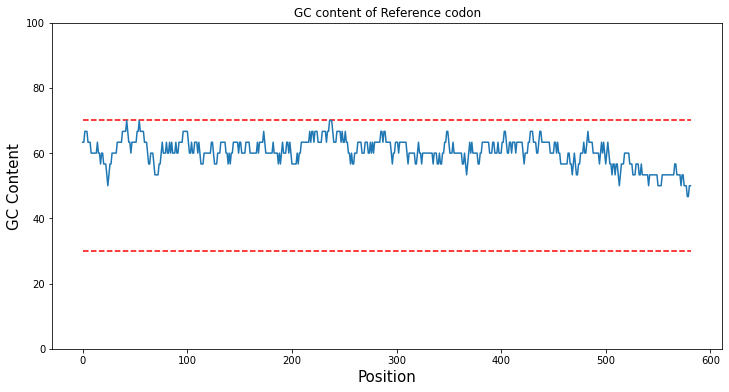

In [10]:
GCd_ref = getGCDistribution(dwave_codon_DNA) 

plt.figure(figsize=(12,6))
plt.ylabel("GC Content", fontsize=15)
plt.xlabel("Position", fontsize=15)
plt.ylim([0,100])
plt.hlines(y=30,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')
plt.hlines(y=70,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')

plt.plot(np.arange(len(GCd_ref)), GCd_ref)
plt.title('GC content of Reference codon')

plt.show()

---
# Results (CAI & GC)

### 1. reference codon DNA <br>


In [14]:
from Bio.SeqUtils import GC
ref_codon_DNA = 'GAGGGCCCGGCGCTGCGGCGCTCCTATTGGCGCCACCTGAGGCGTCTGGTGCTGGGTCCTCCCGAACCGCCGTTCTCGCACGTGTGCCAAGTCGGGGACCCGGTGCTGCGCGGCGTGGCGGCCCCGGTGGAGCGGGCGCAGCTAGGCGGGCCCGAGCTGCAGCGGCTGACGCAACGGCTGGTCCAGGTGATGCGGCGGCGGCGCTGCGTGGGCCTAAGCGCGCCGCAGCTGGGGGTGCCGCGGCAGGTGCTGGCGCTGGAGCTCCCCGAGGCGCTGTGTCGGGAGTGCCCGCCCCGCCAGCGCGCGCTCCGCCAAATGGAGCCCTTCCCCCTGCGCGTGTTCGTGAACCCCAGCCTGCGAGTGCTTGACAGCCGCCTGGTCACCTTTCCCGAGGGCTGCGAGAGCGTCGCCGGCTTCCTGGCCTGCGTGCCCCGCTTCCAGGCGGTGCAGATCTCAGGGCTGGACCCCAATGGAGAACAGGTGGTGTGGCAGGCGAGCGGGTGGGCAGCCCGCATCATCCAGCACGAGATGGACCACCTGCAGGGCTGCCTGTTTATTGACAAAATGGACAGCAGGACGTTCACAAACGTCTATTGGATGAAGGTGAATGACTAA'
BiLSTM_codon_DNA = 'GAAGGTCCGGCACTGCGTCGTAGCTATTGGCGTCATCTGCGTCGTCTGGTGCTGGGTCCGCCGGAACCGCCGTTTAGCCACGTGTGCCAGGTCGGCGATCCGGTGCTGCGTGGCGTGGCGGCACCGGTGGAACGTGCGCAGCTGGGCGGTCCGGAACTGCAGCGTCTGACCCAGCGTCTGGTGCAGGTGATGCGTCGTCGTCGTTGCGTCGGTCTGAGCGCACCGCAGCTGGGCGTGCCGCGTCAGGTGCTGGCGCTGGAACTGCCGGAAGCGCTGTGCCGTGAATGCCCGCCGCGTCAGCGTGCGCTGCGTCAGATGGAACCGTTTCCGCTGCGCGTGTTTGTTAACCCGAGCCTGCGCGTGCTGGATAGCCGTCTGGTGACCTTTCCGGAAGGCTGCGAAAGCGTGGCGGGTTTTCTGGCGTGCGTGCCGCGTTTTCAGGCGGTGCAGATTTCCGGTCTGGATCCGAACGGCGAACAGGTGGTGTGGCAGGCGAGCGGCTGGGCGGCGCGTATTATTCAGCATGAAATGGATCATCTGCAGGGCTGCCTGTTTATTGATAAAATGGATAGCCGTACCTTTACCAACGTCTATTGGATGAAAGTGAACGATTAA'
genscript_codon_DNA = 'GAAGGACCCGCTCTAAGGAGATCATATTGGCGCCATCTGAGACGTCTGGTGTTGGGCCCTCCGGAGCCGCCATTCTCCCATGTTTGTCAGGTCGGTGATCCGGTGTTGCGCGGTGTTGCGGCGCCGGTTGAACGTGCGCAGCTGGGCGGTCCGGAGCTGCAACGTCTGACCCAGCGTCTGGTGCAAGTCATGCGTCGCCGTCGCTGCGTTGGTTTGAGCGCACCGCAGCTGGGCGTCCCGCGCCAAGTGTTAGCCCTGGAACTGCCGGAGGCACTTTGCCGTGAGTGCCCGCCACGTCAGCGTGCTCTCCGCCAAATGGAACCGTTCCCGTTGCGCGTGTTCGTGAACCCGTCCCTGCGTGTTCTGGACTCTCGTTTGGTTACCTTTCCGGAGGGCTGTGAAAGCGTTGCCGGTTTTCTGGCGTGCGTGCCGCGTTTTCAGGCTGTGCAAATTAGCGGTCTCGACCCGAATGGTGAACAGGTAGTTTGGCAGGCGAGCGGCTGGGCAGCGCGTATTATCCAACACGAGATGGACCACCTGCAAGGCTGCCTGTTTATCGACAAGATGGATTCGCGTACGTTCACCAACGTGTACTGGATGAAAGTTAACGATTAA'
genwis_codon_DNA = 'GAAGGACCGGCGCTGCGCCGCAGCTATTGGCGCCATTTACGCCGTCTGGTACTGGGCCCGCCGGAACCGCCGTTTTCCCATGTGTGCCAAGTGGGAGATCCGGTGCTTCGCGGAGTCGCGGCGCCGGTGGAACGCGCTCAACTGGGCGGACCCGAATTACAGCGTCTTACCCAACGTCTGGTGCAAGTGATGCGGCGCCGCCGCTGCGTAGGCCTGAGCGCACCACAGCTGGGCGTGCCGCGACAAGTACTGGCACTTGAGTTACCGGAAGCGCTGTGCAGAGAATGTCCGCCTCGTCAGCGCGCGCTGCGTCAGATGGAACCGTTTCCGCTGCGCGTGTTTGTGAACCCGAGCCTGCGCGTGCTGGATAGCCGCCTGGTGACCTTTCCGGAAGGCTGCGAAAGCGTGGCGGGCTTTCTGGCGTGCGTGCCGCGCTTTCAAGCGGTGCAGATTAGCGGCCTGGATCCGAACGGCGAACAAGTGGTGTGGCAAGCGAGCGGCTGGGCGGCGCGCATTATTCAGCATGAAATGGATCATCTGCAAGGCTGCCTGTTTATTGATAAAATGGATAGCCGCACCTTTACCAACGTGTATTGGATGAAAGTGAACGATTAA'

CAI_hu = CAIs("human")
CAI_ec = CAIs("ecoli")

In [4]:
len(genscript_codon_DNA)

615

In [7]:
len(Genwis)

615

#### Reference codon DNA

------------------------------
reference_codon
CAI of ref_codon for human: 0.7876879260559179
CAI of ref_codon for ecoli: 0.6626674257312732
GC of ref_codon: 69.4308943089431


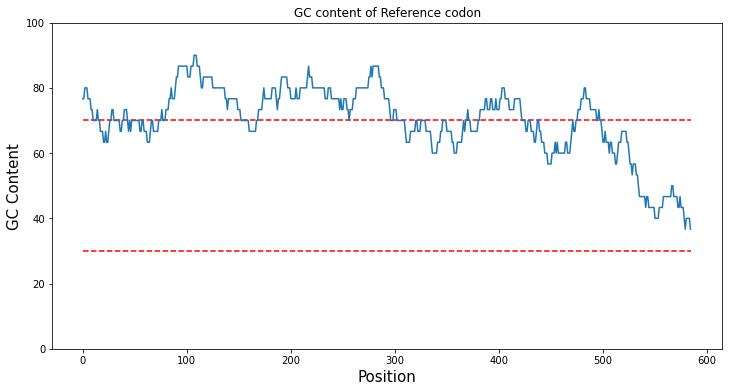

In [23]:
print("-"*30)
print("reference_codon")
print(f"CAI of ref_codon for human: {CAI_hu(ref_codon_DNA)}")
print(f"CAI of ref_codon for ecoli: {CAI_ec(ref_codon_DNA)}")
print(f"GC of ref_codon: {GC(ref_codon_DNA)}")

GCd_ref = getGCDistribution(ref_codon_DNA) 

plt.figure(figsize=(12,6))
plt.ylabel("GC Content", fontsize=15)
plt.xlabel("Position", fontsize=15)
plt.ylim([0,100])
plt.hlines(y=30,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')
plt.hlines(y=70,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')

plt.plot(np.arange(len(GCd_ref)), GCd_ref)
plt.title('GC content of Reference codon')

plt.show()

#### BiLSTM codon DNA

------------------------------
BiLSTM_codon
CAI of BiLSTM_opt_codon for human: 0.682288617477938
CAI of BiLSTM_opt_codon for ecoli: 0.9662881947629263
GC of BiLSTM_opt_codon: 62.4390243902439


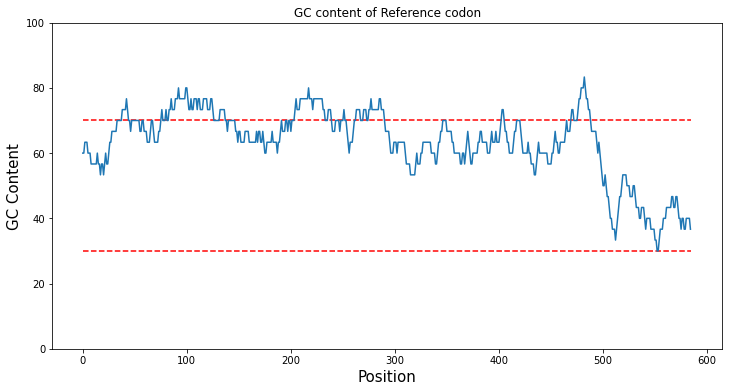

In [24]:
print("-"*30)
print("BiLSTM_codon")
print(f"CAI of BiLSTM_opt_codon for human: {CAI_hu(BiLSTM_codon_DNA)}")
print(f"CAI of BiLSTM_opt_codon for ecoli: {CAI_ec(BiLSTM_codon_DNA)}")
print(f"GC of BiLSTM_opt_codon: {GC(BiLSTM_codon_DNA)}")

GCd_ref = getGCDistribution(BiLSTM_codon_DNA) 

plt.figure(figsize=(12,6))
plt.ylabel("GC Content", fontsize=15)
plt.xlabel("Position", fontsize=15)
plt.ylim([0,100])
plt.hlines(y=30,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')
plt.hlines(y=70,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')

plt.plot(np.arange(len(GCd_ref)), GCd_ref)
plt.title('GC content of Reference codon')

plt.show()

#### Genscript DNA

------------------------------
Genscript_codon
CAI of Genscript_codon for human: 0.6428468577813087
CAI of Genscript_codon for ecoli: 0.7326141384628243
GC of Genscript_codon: 59.83739837398374


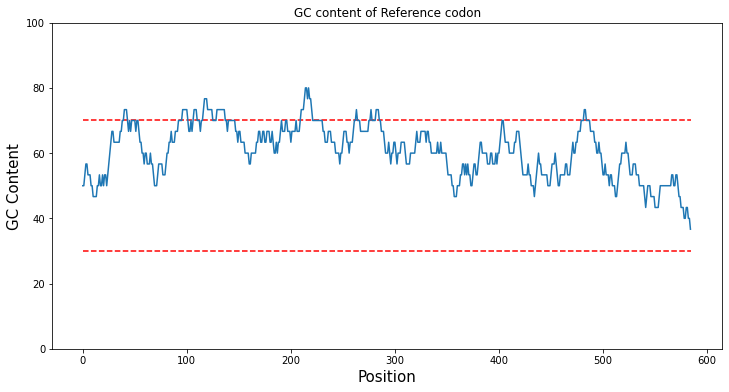

In [17]:
print("-"*30)
print("Genscript_codon")
print(f"CAI of Genscript_codon for human: {CAI_hu(genscript_codon_DNA)}")
print(f"CAI of Genscript_codon for ecoli: {CAI_ec(genscript_codon_DNA)}")
print(f"GC of Genscript_codon: {GC(genscript_codon_DNA)}")

GCd_ref = getGCDistribution(genscript_codon_DNA) 

plt.figure(figsize=(12,6))
plt.ylabel("GC Content", fontsize=15)
plt.xlabel("Position", fontsize=15)
plt.ylim([0,100])
plt.hlines(y=30,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')
plt.hlines(y=70,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')

plt.plot(np.arange(len(GCd_ref)), GCd_ref)
plt.title('GC content of Reference codon')

plt.show()

#### Genwis DNA

------------------------------
Genwis_codon
CAI of Genwis_codon for human: 0.6853522125123164
CAI of Genwis_codon for ecoli: 0.831262679672495
GC of Genwis_codon: 61.300813008130085


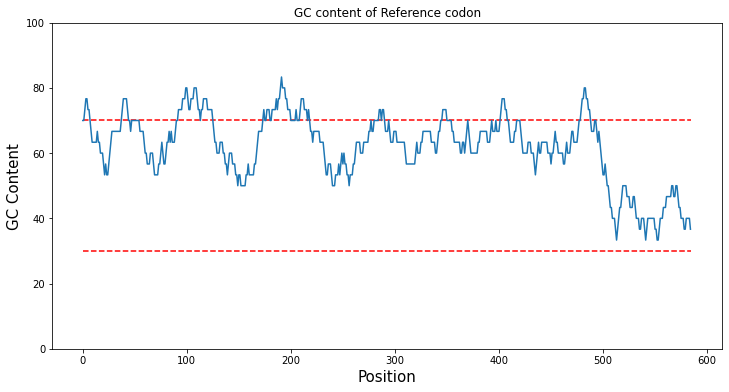

In [16]:
print("-"*30)
print("Genwis_codon")
print(f"CAI of Genwis_codon for human: {CAI_hu(genwis_codon_DNA)}")
print(f"CAI of Genwis_codon for ecoli: {CAI_ec(genwis_codon_DNA)}")
print(f"GC of Genwis_codon: {GC(genwis_codon_DNA)}")

GCd_ref = getGCDistribution(genwis_codon_DNA) 

plt.figure(figsize=(12,6))
plt.ylabel("GC Content", fontsize=15)
plt.xlabel("Position", fontsize=15)
plt.ylim([0,100])
plt.hlines(y=30,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')
plt.hlines(y=70,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')

plt.plot(np.arange(len(GCd_ref)), GCd_ref)
plt.title('GC content of Reference codon')

plt.show()

### 2. Dwave codon DNA <br>

#### Block size: 5, $c_f=0.05$, $c_{GC}=10$, $c_R=0$, $\rho_T=0.6$, $\epsilon=2$, $\infty=4$

CAI of dwave_codon for human : 0.6445381693631448
CAI of dwave_codon for ecoli : 0.8715684286745264
GC of dwave_codon : 59.64052287581699


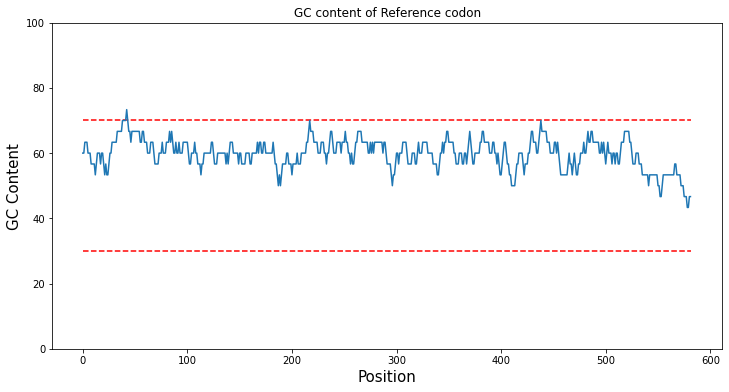

In [26]:
df_opt_codon = pd.read_csv('./result_data/HPDF_bs5_c_f0.05_c_GC10_c_R0_rho_T0.6_epsilon2_infty4.csv', index_col=0)
dwave_codon_RNA = "".join(df_opt_codon['codon'])
dwave_codon_DNA = dwave_codon_RNA.replace("U", "T")

#CAI
CAI_hu = CAIs("human")
CAI_ec = CAIs("ecoli")

CAI_hu(dwave_codon_DNA)
CAI_ec(dwave_codon_DNA)

print(f"CAI of dwave_codon for human : {CAI_hu(dwave_codon_DNA)}")
print(f"CAI of dwave_codon for ecoli : {CAI_ec(dwave_codon_DNA)}")
print(f"GC of dwave_codon : {GC(dwave_codon_DNA)}")



GCd_ref = getGCDistribution(dwave_codon_DNA) 

plt.figure(figsize=(12,6))
plt.ylabel("GC Content", fontsize=15)
plt.xlabel("Position", fontsize=15)
plt.ylim([0,100])
plt.hlines(y=30,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')
plt.hlines(y=70,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')

plt.plot(np.arange(len(GCd_ref)), GCd_ref)
plt.title('GC content of Reference codon')

plt.show()

In [27]:
dwave_codon_DNA

'GAAGGTCCGGCGTTACGTCGCAGCTATTGGCGTCATCTGCGTCGTCTGGTTCTGGGTCCGCCGGAACCGCCGTTTAGCCATGTGTGCCAGGTGGGTGATCCGGTTCTGCGTGGTGTTGCTGCACCGGTTGAACGTGCACAACTGGGTGGTCCGGAACTGCAACGTCTGACCCAACGTCTGGTGCAGGTGATGCGTCGTCGTCGTTGTGTGGGTTTATCTGCGCCGCAACTGGGTGTTCCGCGTCAGGTTCTGGCACTGGAACTGCCGGAAGCGCTGTGTCGTGAATGTCCGCCGCGTCAACGTGCACTGCGTCAAATGGAACCGTTCCCGCTGCGCGTGTTTGTGAATCCGAGCCTGCGTGTGCTGGATAGCCGTCTGGTGACCTTTCCGGAAGGCTGCGAAAGCGTGGCGGGTTTTCTGGCATGTGTTCCGCGTTTTCAGGCGGTGCAGATCAGCGGCCTGGATCCGAACGGTGAACAGGTTGTTTGGCAGGCGAGTGGTTGGGCAGCACGCATCATCCAGCACGAGATGGACCACCTGCAGGGCTGCCTGTTTATCGACAAGATGGACAGCCGCACCTTTACCAACGTGTACTGGATGAAGGTGAACGAC'

#### Block size: 5, $c_f=0.05$, $c_{GC}=10$, $c_R=0.01$, $\rho_T=0.6$, $\epsilon=2$, $\infty=4$

CAI of dwave_codon for human : 0.6709249130677576
CAI of dwave_codon for ecoli : 0.8384396179093649
GC of dwave_codon : 60.294117647058826


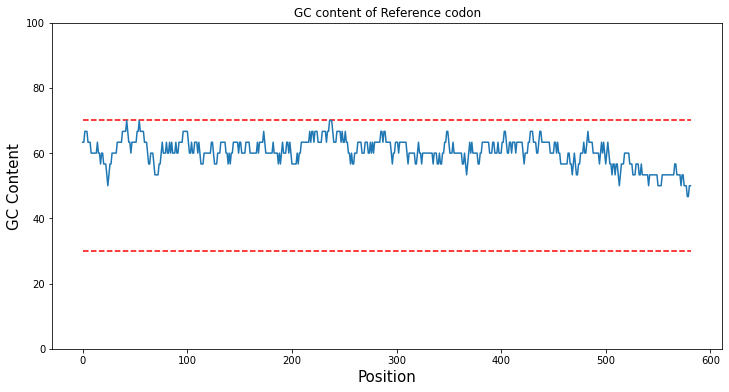

In [11]:
df_opt_codon = pd.read_csv('./result_data/HPDF_bs5_c_f0.05_c_GC10_c_R0.01_rho_T0.6_epsilon2_infty4.csv', index_col=0)
dwave_codon_RNA = "".join(df_opt_codon['codon'])
dwave_codon_DNA = dwave_codon_RNA.replace("U", "T")

#CAI
CAI_hu = CAIs("human")
CAI_ec = CAIs("ecoli")

CAI_hu(dwave_codon_DNA)
CAI_ec(dwave_codon_DNA)

print(f"CAI of dwave_codon for human : {CAI_hu(dwave_codon_DNA)}")
print(f"CAI of dwave_codon for ecoli : {CAI_ec(dwave_codon_DNA)}")
print(f"GC of dwave_codon : {GC(dwave_codon_DNA)}")



GCd_ref = getGCDistribution(dwave_codon_DNA) 

plt.figure(figsize=(12,6))
plt.ylabel("GC Content", fontsize=15)
plt.xlabel("Position", fontsize=15)
plt.ylim([0,100])
plt.hlines(y=30,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')
plt.hlines(y=70,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')

plt.plot(np.arange(len(GCd_ref)), GCd_ref)
plt.title('GC content of Reference codon')

plt.show()

In [12]:
dwave_codon_DNA

'GAAGGTCCGGCACTGCGTCGCAGCTATTGGCGTCATCTGCGTCGTCTGGTGTTAGGTCCGCCGGAACCGCCGTTTAGCCACGTGTGTCAGGTTGGTGATCCGGTGCTGCGTGGTGTAGCAGCACCGGTTGAACGTGCGCAGTTAGGTGGTCCGGAACTGCAGCGTCTGACTCAGCGTCTGGTGCAGGTGATGCGTCGTCGTCGTTGTGTGGGTCTGAGTGCACCGCAGTTAGGTGTGCCGCGTCAGGTGCTGGCACTGGAACTGCCGGAAGCGCTGTGTCGTGAATGTCCACCGCGTCAGCGTGCACTGCGTCAGATGGAACCGTTCCCGCTGCGTGTGTTCGTGAATCCGAGTCTGCGCGTGCTGGATAGTCGCCTGGTTACCTTCCCGGAAGGTTGCGAGAGCGTAGCAGGCTTCCTGGCATGTGTGCCGCGTTTCCAGGCAGTGCAGATCAGCGGCCTGGATCCGAACGGTGAACAGGTAGTGTGGCAGGCATCTGGTTGGGCAGCACGCATCATCCAGCACGAGATGGATCACCTGCAAGGCTGCCTGTTCATCGACAAGATGGACAGTCGCACGTTCACCAACGTGTACTGGATGAAGGTGAACGAC'

#### Block size: 8, $c_f=0.01$, $c_{GC}=10$, $c_R=0$, $\rho_T=0.6$, $\epsilon=2$, $\infty=4$

CAI of dwave_codon for human : 0.6414828003344591
CAI of dwave_codon for ecoli : 0.82267328194055
GC of dwave_codon : 59.31372549019608


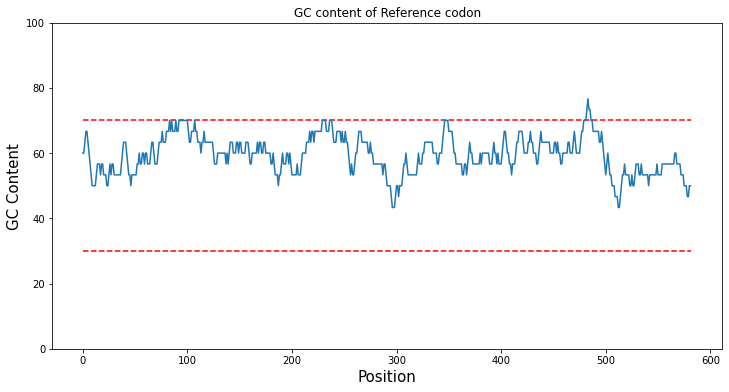

In [19]:
df_opt_codon = pd.read_csv('./result_data/HPDF_bs8_c_f0.01_c_GC10_c_R0_rho_T0.6_epsilon2_infty4.csv', index_col=0)
dwave_codon_RNA = "".join(df_opt_codon['codon'])
dwave_codon_DNA = dwave_codon_RNA.replace("U", "T")

#CAI
CAI_hu = CAIs("human")
CAI_ec = CAIs("ecoli")

CAI_hu(dwave_codon_DNA)
CAI_ec(dwave_codon_DNA)

print(f"CAI of dwave_codon for human : {CAI_hu(dwave_codon_DNA)}")
print(f"CAI of dwave_codon for ecoli : {CAI_ec(dwave_codon_DNA)}")
print(f"GC of dwave_codon : {GC_dwave}")



GCd_ref = getGCDistribution(dwave_codon_DNA) 

plt.figure(figsize=(12,6))
plt.ylabel("GC Content", fontsize=15)
plt.xlabel("Position", fontsize=15)
plt.ylim([0,100])
plt.hlines(y=30,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')
plt.hlines(y=70,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')

plt.plot(np.arange(len(GCd_ref)), GCd_ref)
plt.title('GC content of Reference codon')

plt.show()

#### Block size: 8, $c_f=0.05$, $c_{GC}=10$, $c_R=0$, $\rho_T=0.6$, $\epsilon=2$, $\infty=4$

CAI of dwave_codon for human : 0.6557085196351714
CAI of dwave_codon for ecoli : 0.8633182866924429
GC of dwave_codon : 60.78431372549019


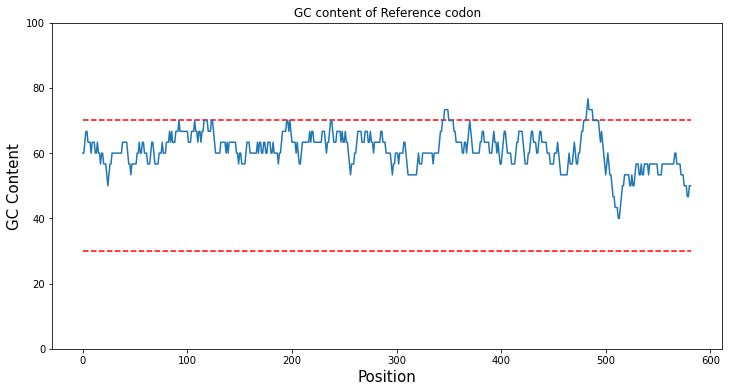

In [12]:
df_opt_codon = pd.read_csv('./result_data/HPDF_bs8_c_f0.05_c_GC10_c_R0_rho_T0.6_epsilon2_infty4.csv', index_col=0)
dwave_codon_RNA = "".join(df_opt_codon['codon'])
dwave_codon_DNA = dwave_codon_RNA.replace("U", "T")

#CAI
CAI_hu = CAIs("human")
CAI_ec = CAIs("ecoli")

CAI_hu(dwave_codon_DNA)
CAI_ec(dwave_codon_DNA)

print(f"CAI of dwave_codon for human : {CAI_hu(dwave_codon_DNA)}")
print(f"CAI of dwave_codon for ecoli : {CAI_ec(dwave_codon_DNA)}")
print(f"GC of dwave_codon : {GC_dwave}")



GCd_ref = getGCDistribution(dwave_codon_DNA) 

plt.figure(figsize=(12,6))
plt.ylabel("GC Content", fontsize=15)
plt.xlabel("Position", fontsize=15)
plt.ylim([0,100])
plt.hlines(y=30,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')
plt.hlines(y=70,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')

plt.plot(np.arange(len(GCd_ref)), GCd_ref)
plt.title('GC content of Reference codon')

plt.show()

#### Block size: 8, $c_f=0.1$, $c_{GC}=10$, $c_R=0$, $\rho_T=0.6$, $\epsilon=2$, $\infty=4$

CAI of dwave_codon for human : 0.6850240667911434
CAI of dwave_codon for ecoli : 0.8613108293506399
GC of dwave_codon : 60.947712418300654


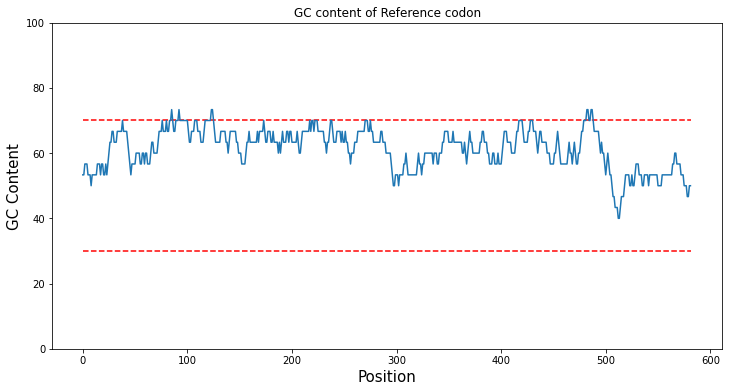

In [18]:
df_opt_codon = pd.read_csv('./result_data/HPDF_bs8_c_f0.1_c_GC10_c_R0_rho_T0.6_epsilon2_infty4.csv', index_col=0)
dwave_codon_RNA = "".join(df_opt_codon['codon'])
dwave_codon_DNA = dwave_codon_RNA.replace("U", "T")

#CAI
CAI_hu = CAIs("human")
CAI_ec = CAIs("ecoli")

CAI_hu(dwave_codon_DNA)
CAI_ec(dwave_codon_DNA)

print(f"CAI of dwave_codon for human : {CAI_hu(dwave_codon_DNA)}")
print(f"CAI of dwave_codon for ecoli : {CAI_ec(dwave_codon_DNA)}")
print(f"GC of dwave_codon : {GC(dwave_codon_DNA)}")



GCd_ref = getGCDistribution(dwave_codon_DNA) 

plt.figure(figsize=(12,6))
plt.ylabel("GC Content", fontsize=15)
plt.xlabel("Position", fontsize=15)
plt.ylim([0,100])
plt.hlines(y=30,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')
plt.hlines(y=70,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')

plt.plot(np.arange(len(GCd_ref)), GCd_ref)
plt.title('GC content of Reference codon')

plt.show()

#### Block size: 10, $c_f=0.05$, $c_{GC}=10$, $c_R=0$, $\rho_T=0.6$, $\epsilon=2$, $\infty=4$

CAI of dwave_codon for human : 0.6542158817696027
CAI of dwave_codon for ecoli : 0.8161581437046183
GC of dwave_codon : 60.294117647058826


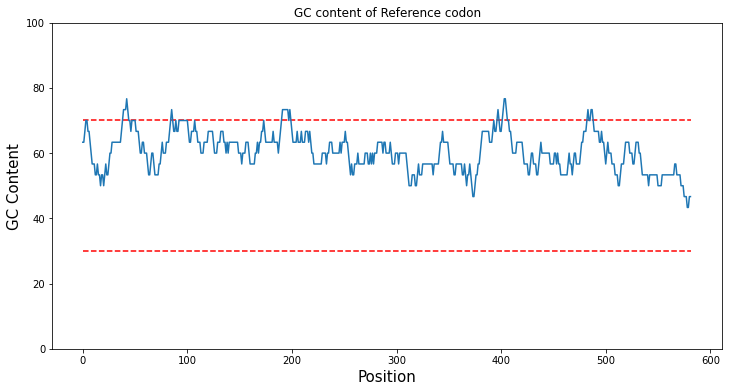

In [21]:
df_opt_codon = pd.read_csv('./result_data/HPDF_bs10_c_f0.05_c_GC10_c_R0_rho_T0.6_epsilon2_infty4.csv', index_col=0)
dwave_codon_RNA = "".join(df_opt_codon['codon'])
dwave_codon_DNA = dwave_codon_RNA.replace("U", "T")

#CAI
CAI_hu = CAIs("human")
CAI_ec = CAIs("ecoli")

CAI_hu(dwave_codon_DNA)
CAI_ec(dwave_codon_DNA)

print(f"CAI of dwave_codon for human : {CAI_hu(dwave_codon_DNA)}")
print(f"CAI of dwave_codon for ecoli : {CAI_ec(dwave_codon_DNA)}")
print(f"GC of dwave_codon : {GC(dwave_codon_DNA)}")



GCd_ref = getGCDistribution(dwave_codon_DNA) 

plt.figure(figsize=(12,6))
plt.ylabel("GC Content", fontsize=15)
plt.xlabel("Position", fontsize=15)
plt.ylim([0,100])
plt.hlines(y=30,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')
plt.hlines(y=70,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')

plt.plot(np.arange(len(GCd_ref)), GCd_ref)
plt.title('GC content of Reference codon')

plt.show()

In [22]:
dwave_codon_DNA

'GAAGGTCCGGCGCTGCGTCGTAGCTATTGGCGGCATTTACGTCGTCTGGTCCTGGGTCCCCCGGAACCGCCGTTTAGCCATGTTTGCCAGGTTGGCGATCCGGTCCTGCGTGGCGTTGCAGCACCGGTAGAACGCGCACAACTGGGTGGCCCAGAACTCCAGCGTCTGACACAGCGTCTGGTGCAGGTTATGCGCCGTCGCCGTTGTGTGGGTCTGTCCGCGCCGCAGTTAGGTGTTCCACGCCAAGTACTGGCGCTGGAACTGCCAGAAGCGCTGTGTCGTGAATGTCCACCTCGTCAGCGTGCACTGCGCCAAATGGAACCGTTTCCGCTGCGTGTCTTTGTGAATCCGTCCCTTCGCGTGCTGGACAGCCGTTTAGTTACCTTCCCGGAAGGTTGCGAAAGCGTGGCGGGCTTCCTGGCGTGCGTTCCGCGTTTTCAAGCGGTGCAGATCAGTGGCCTGGATCCGAATGGCGAACAGGTTGTTTGGCAGGCGTCTGGTTGGGCGGCGCGCATCATTCAGCACGAAATGGACCACCTGCAGGGCTGCCTGTTCATCGACAAAATGGACAGCCGCACCTTCACCAACGTGTATTGGATGAAGGTGAACGAC'

#### Block size: 10, $c_f=0.05$, $c_{GC}=10$, $c_R=0.01$, $\rho_T=0.6$, $\epsilon=2$, $\infty=4$

CAI of dwave_codon for human : 0.6743860498182793
CAI of dwave_codon for ecoli : 0.7665748355554213
GC of dwave_codon : 60.62091503267974


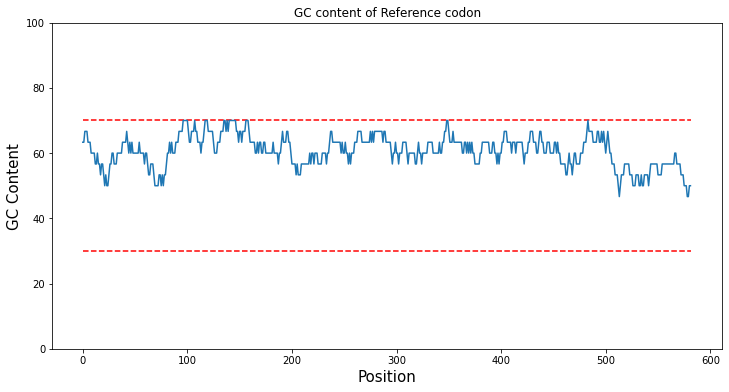

In [19]:
df_opt_codon = pd.read_csv('./result_data/HPDF_bs10_c_f0.05_c_GC10_c_R0.01_rho_T0.6_epsilon2_infty4.csv', index_col=0)
dwave_codon_RNA = "".join(df_opt_codon['codon'])
dwave_codon_DNA = dwave_codon_RNA.replace("U", "T")

#CAI
CAI_hu = CAIs("human")
CAI_ec = CAIs("ecoli")

CAI_hu(dwave_codon_DNA)
CAI_ec(dwave_codon_DNA)

print(f"CAI of dwave_codon for human : {CAI_hu(dwave_codon_DNA)}")
print(f"CAI of dwave_codon for ecoli : {CAI_ec(dwave_codon_DNA)}")
print(f"GC of dwave_codon : {GC(dwave_codon_DNA)}")



GCd_ref = getGCDistribution(dwave_codon_DNA) 

plt.figure(figsize=(12,6))
plt.ylabel("GC Content", fontsize=15)
plt.xlabel("Position", fontsize=15)
plt.ylim([0,100])
plt.hlines(y=30,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')
plt.hlines(y=70,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')

plt.plot(np.arange(len(GCd_ref)), GCd_ref)
plt.title('GC content of Reference codon')

plt.show()

In [20]:
dwave_codon_DNA

'GAAGGTCCGGCGCTGCGTCGCAGTTATTGGCGTCATCTGCGACGTCTGGTTCTAGGACCACCGGAACCGCCGTTCTCTCATGTCTGTCAGGTTGGTGATCCGGTTCTGCGCGGTGTTGCGGCTCCGGTTGAACGTGCACAGCTGGGCGGTCCAGAACTGCAGCGGCTGACGCAGCGTCTGGTGCAGGTTATGCGTCGACGTCGCTGTGTGGGTCTGAGTGCACCGCAATTAGGTGTTCCGCGTCAGGTGCTGGCACTTGAACTGCCGGAGGCACTGTGTCGTGAGTGTCCACCGCGTCAGCGTGCTCTGCGTCAGATGGAACCGTTCCCTCTCCGCGTCTTCGTGAATCCGAGTCTGCGCGTGCTGGACTCTCGCCTGGTTACCTTCCCGGAAGGCTGTGAGTCAGTCGCTGGCTTCCTGGCATGTGTGCCGCGTTTCCAGGCAGTGCAGATCAGCGGCCTGGATCCGAATGGCGAACAGGTAGTGTGGCAAGCGTCTGGTTGGGCAGCGCGCATCATCCAGCACGAGATGGATCATCTGCAAGGCTGCCTGTTCATCGACAAGATGGACAGCCGCACGTTCACCAACGTGTACTGGATGAAGGTGAACGAC'